In [3]:
import numpy as np

In [3]:
import Cython

In [4]:
%load_ext Cython

In [1]:
import pandas as pd
import glob
import os
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from scipy import signal
import pdb
import time
import calendar
import pyfftw
import pickle
from tqdm import tqdm
from numba import jit

# utility functions

def save_obj(obj,name):
    with open(os.getcwd() + '/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open(os.getcwd() + '/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

def save_params(obj,name):
    idx = 1
    file_list = [os.path.basename(x) for x in glob.glob(os.getcwd()+'/*')]
    new_filename = name
    while new_filename+'.csv' in file_list:
        new_filename = name + '_' + f'{idx:03}'
        idx += 1
    save_obj(obj,new_filename)


# note that ω is in units of Hz, not radians/sec

class microring:
    
    def __init__(self,R=60e-6,height=1e-6,width=2.3e-6,ng=2.2,Qc=1e6,Qi=1e6,n2=2.4e-19,
                δnorm_range=[-8,12],ω_range=[],λ_range=[],ω0=299792458/1.550e-6,λ0=None,
                total_time=10e-6,ω_sweep_speed=None,λ_sweep_speed=None,Qc_import=None,
                Qc_file=None,Dint_file=None,dt=1e-3/2,
                Nmodes=2**8,pump=200e-3,snapshots=2000,mode_offset=0,Dint_degrees=9,save=True,filename='combsol',
                set_Dint=None,seed=None,aux=None):
        # set constants
        self.constants()
        
        # set ring parameters
        self.ring_parameters(R,height,width,ng,Nmodes,Qi,mode_offset,aux)

        if Qc_import is not None:
            self.Qc = Qc_import
            self.Ql = (1/self.Qc[len(Qc_import)//2]+1/Qi)**-1
        else:
            self.Qc = Qc
            self.Ql = (1/Qc+1/Qi)**-1
            self.Δωext = ω0/self.Qc # 25e6 # single value
        
        # laser parameters (ω is in Hz units)
        if λ0:
            self.λ0 = λ0
            self.ω0 = self.c/λ0
        else:
            self.ω0 = ω0
            self.λ0 = self.c/self.ω0
        
        # linewidth of resonance useful for normalization
        self.Δωtot = self.ω0/self.Ql # total coupling rate at pump frequency
        self.Δωi = self.ω0/self.Qi
        
        if ω_range or λ_range:
            try:
                self.λ_start = λ_range[0]
                self.λ_end = λ_range[1]
                self.ω_start = self.c/λ_start
                self.ω_end = self.c/λ_end
            except:
                self.ω_start = ω_range[0]
                self.ω_end = ω_range[1]
                self.λ_start = self.c/self.ω_start
                self.λ_end = self.c/self.ω_end
            self.δnorm_range = [(self.ω0-self.ω_start)/(self.Δωtot/2),(self.ω0-self.ω_end)/(self.Δωtot/2)]
        else:
            self.δnorm_range = δnorm_range # normalized detuning array (normalized in terms of half linewidths)
            self.ω_start = self.ω0 - self.δnorm_range[0]*(self.Δωtot/2)
            self.ω_end = self.ω0 - self.δnorm_range[1]*(self.Δωtot/2)
            self.λ_start = self.c/self.ω_start
            self.λ_end = self.c/self.ω_end

        print(f'ω_start = {self.ω_start/1e12} THz, ω_end = {self.ω_end/1e12} THz')
        print(f'λ_start = {self.λ_start*1e9} nm, λ_end = {self.λ_end*1e9} nm')
        print(f'normalized detunings = [ {self.δnorm_range[0]} , {self.δnorm_range[1]} ] (relevant parameters: δnorm_range)')
        
        if total_time and (ω_sweep_speed is None) and (λ_sweep_speed is None):
            self.total_time = total_time
            self.ω_sweep_speed = np.abs(self.ω_end-self.ω_start)/total_time
            self.λ_sweep_speed = np.abs(self.λ_end-self.λ_start)/total_time
            print(f'sweep speed (ω space) = {self.ω_sweep_speed/1e9} GHz/s \nsweep speed (λ space) = {self.λ_sweep_speed*1e9} nm/s')
        elif ω_sweep_speed:
            self.ω_sweep_speed = ω_sweep_speed
            self.total_time = np.abs(self.ω_end-self.ω_start)/self.ω_sweep_speed
            print(f'total time = {self.total_time}')
        elif λ_sweep_speed:
            self.λ_sweep_speed = λ_sweep_speed
            self.total_time = np.abs(self.λ_end-self.λ_start)/self.λ_sweep_speed
            print(f'total time = {self.total_time}')
        else:
            print('no sweep speed or total time given (relevant parameters: λ_sweep_speed, ω_sweep_speed, total_time)')
        
        self.Tnorm = self.total_time*self.Δωtot/2
        self.dt=dt/(pump/0.003) # normalized dt, dt is not in units of seconds
        print(f"real time = {self.total_time}, normalized time = {self.Tnorm} (relevant parameters: total_time), dt = {dt}")
        self.Nsim = self.Tnorm//self.dt
        
        print(f'Simulation points = {self.Nsim} (relevant parameters: dt)')
        
        self.δarr = np.linspace(self.ω0-self.ω_start,self.ω0-self.ω_end,int(self.Nsim),dtype=np.complex128)# replaced last term with int(self.Nsim)
        print(f'detuning at start = {self.δarr[0]/1e9} GHz, detuning at end = {self.δarr[-1]/1e9} GHz (relevant parametes: ω_range, λ_range)')
        
        self.idx = Nmodes//2-mode_offset
        self.mode_arr = np.arange(-Nmodes/2+mode_offset,Nmodes/2+mode_offset)
        self.μ = self.fftshift(self.mode_arr,self.idx)
        self.ωarr = self.mode_arr*self.FSR+self.ω0

        if Qc_import is not None:
            self.Δωext = self.ωarr/self.Qc
            self.Δωext_arr = self.Δωext 
        
        # find coefficients for Dint if a file is given, if not, use the default.  The file has to have two columns with name 'lambda' and 'Dint'
        if Qc_file:
            df_Qc = pd.read_csv(Qc_file)
            self.Qc_coeffs = np.polyfit(3e2/df_Qc['lambda'],df_Qc['Qc'],deg=9)
            self.Qc = self.PolyCoefficients(self.ωarr/1e12,self.Qc_coeffs)
            print(Qc/1e6)
            self.Δωext = self.ωarr/self.Qc
            self.Δωext_arr = self.Δωext

        if Dint_file:
            df = pd.read_csv(Dint_file)
            df['lambda']=3e2/df['lambda']
            self.Dint_coeffs = np.polyfit(df['lambda'],df['Dint'],deg=Dint_degrees)
        else:
            self.Dint_coeffs = np.array([ 7.38392840e-07, -1.08366836e-03,  6.20323154e-01, -1.52824970e+02,
                                         2.00631574e+01,  9.25526200e+06, -2.25798494e+09,  2.33413386e+11,
                                         -9.25346061e+12])
        if set_Dint is not None:
            self.Dint_arr = set_Dint
            self.ωarr_adjusted = self.ωarr+self.Dint_arr
            self.Dint_arr = self.fftshift(self.Dint_arr,self.idx)
        else:
            self.Dint_arr = self.PolyCoefficients(self.ωarr/1e12,self.Dint_coeffs)
            self.Dint_arr = self.fftshift(self.Dint_arr,self.idx) # self.Dint_arr = np.fft.ifftshift(self.Dint_arr)
            self.Dint_arr -= self.Dint_arr[0]
            self.ωarr_adjusted = self.ωarr+self.ifftshift(self.Dint_arr,self.idx)
        self.n2 = n2 # m^2 / W 
        self.Veff = self.A*self.L
        self.g0 = self.h*self.ω0**2*self.c*self.n2/self.ng**2/self.Veff # nonlinear gain (approximation since ω0 should represent laser wavelength)
        # note that g0 has units of Hz.
        self.γ = self.n2*self.ω0/self.c/self.A
            
        # set vaccuum noise fluctuations that will initiate the comb
        self.normalization = np.sqrt(self.g0*2/self.Δωtot)
        self.noise_norm = self.set_noise(seed=seed)
        self.pump = pump
        self.Nsnapshots = snapshots
        self.δ_snapshots = np.linspace(self.δnorm_range[0],self.δnorm_range[1],self.Nsnapshots)
        self.sol = np.ndarray(shape=(self.Nsnapshots, self.Nmodes), dtype='complex')
        self.F_arr = np.zeros(self.Nmodes,dtype='complex') 

        try: # temporary solution for coupling Q array
            self.F_arr[0] = np.sqrt(8*self.g0*self.fftshift(self.Δωext_arr,self.idx)[0]*self.pump/(self.h*self.ω0)/self.Δωtot**3) # normalized power coupled into waveguide
            self.Δωext = self.fftshift(self.Δωext_arr,self.idx)
            print(f"normalized external coupling rate at pump = {self.fftshift(self.Δωext_arr/(self.ω0/1e6),self.idx)[0]}")
        except Exception as e: # temporary solution for coupling Q single value
            self.F_arr[0] = np.sqrt(8*self.g0*self.Δωext*self.pump/(self.h*self.ω0)/self.Δωtot**3) 

        print(f'g0 = {self.g0}, Veff = {self.Veff}, F^2 = {np.abs(self.F_arr[0])**2}')
        self.norm_factor = np.sqrt(2*self.g0/self.Δωtot)
        self.sol[0,:]=self.noise_norm

        if Qc_file is None and Qc_import is None:
            self.plot_Dint()
        else:
            self.plot_Dint_Qc()

        
        self.save = save
        self.filename = filename
        if '.csv' in self.filename:
            raise Exception("do not include '.csv' or suffix in filename")
        
    def PolyCoefficients(self, x, coeffs):
        """ Returns a polynomial for ``x`` values for the ``coeffs`` provided.

        The coefficients must be in ascending order (``x**0`` to ``x**o``).
        """
        o = len(coeffs)
        print(f'polynomial of order {o-1}.')
        y = 0
        coeffs = coeffs[::-1]
        for i in range(o):
            y += coeffs[i]*x**i
        return y

    def set_noise(self,seed):
        if seed:
            np.random.seed(seed=seed)
        energy = self.h*(self.fftshift(self.ωarr_adjusted,self.idx))
        phase_noise = 2*np.pi*np.random.rand(self.Nmodes)
        arr = np.random.rand(self.Nmodes)
        normalized_noise = self.normalization*arr*np.sqrt(energy/2)*np.exp(1j*phase_noise)*self.Nmodes
        return normalized_noise


    def split_step(self,plan_fft=False,threads=1,wisdom=None,fastmath=False):
        """split step method, initial seed starts off in the frequency domain, note that due to the randomness of
        the seed noise, the solutions may not be the same even when run multiple times with the same parameters"""
        with tqdm(total=self.Nsnapshots) as pbar:
            divbysnapshot = self.Nsim//self.Nsnapshots
            sol_track = 0
            ψf = self.sol[0,:]
            F_arr = np.fft.ifft(self.F_arr)*(self.Nmodes)
            ψf += self.F_arr*self.Nmodes*self.dt

            ################################
            # convert to local variables
            dt = self.dt
            Dint_arr = self.Dint_arr
            noise_norm = self.noise_norm
            Δωext = self.Δωext
            Δωi = self.Δωi
            Δωtot = self.Δωtot
            δarr = self.δarr
            Nsim = self.Nsim
            ################################

            '''Plan ifft/fft, pre-allocate resources, this will speed up the FFT quite a bit compared to regular np.fft
            note that the bottleneck is usually the array assignments and dispersion calculations within the loop,
            not the fft'''
            ifft_arr = pyfftw.empty_aligned(self.Nmodes,dtype='complex128',n=16) # frequency domain
            fft_arr = pyfftw.empty_aligned(self.Nmodes,dtype='complex128',n=16) # time domain
            fft_object = pyfftw.FFTW(fft_arr,ifft_arr,threads=threads,flags=('FFTW_MEASURE',))
            ifft_object = pyfftw.FFTW(ifft_arr,fft_arr,direction='FFTW_BACKWARD',threads=threads,flags=('FFTW_MEASURE',))
            ifft_arr[:] = ψf
            
            self.ifft_arr = ifft_arr
            self.fft_arr = fft_arr
            self.fft_object = fft_object
            self.ifft_object = ifft_object
            # some additional ways of using pyfftw builders to initialize fft arrays in memory
            # sometimes overhead of setting up additional threads is not worth it
            # ifft_object = pyfftw.builders.ifft(ifft_arr,threads=1)
            # Plan fft
            # fft_object = pyfftw.builders.fft(fft_arr,threads=1)

            # Define just in time compilations in Numba for significant speedup in computation time.
            # @jit(nopython=True,fastmath=fastmath)
            # def worker_D(i):
            #     return np.exp(-(dt/2) *((Δωext+Δωi)/Δωtot+1j*(Dint_arr + δarr[i])*2/Δωtot )) # or -self.F_arr*self.Nmodes/ifft_arr here

            # @jit(nopython=True,fastmath=fastmath)
            # def worker_D2(i):
            #     return np.exp(-(dt/2) *((Δωext+Δωi)/Δωtot+1j*(Dint_arr + δarr[i])*2/Δωtot ))

            # @jit(nopython=True,fastmath=fastmath)
            # def worker_N(fft_arr):
            #     return np.exp(dt *(1j *  np.abs(fft_arr) ** 2 + F_arr/fft_arr)) * fft_arr

            # @jit(nopython=True)
            # def worker_multiply(Dispersion,ifft_arr):
            #     return Dispersion * ifft_arr

            # @jit(nopython=True)
            # def all():
            #     for i in range(int(Nsim)):
            #         Dispersion = np.exp(-(dt/2) *((Δωext+Δωi)/Δωtot+1j*(Dint_arr + δarr[i])*2/Δωtot )) # or -self.F_arr*self.Nmodes/ifft_arr here
            #         # Calculating the dispersion term only once is important for speeding up the computation
            #         # Use as little array assignments as possible for additional speedup
            #         with objmode(out='complex128[:]'):
            #             ifft_arr[:] = Dispersion * ifft_arr
            #             ifft_object()
            #             fft_arr[:] = np.exp(dt *(1j *  np.abs(fft_arr) ** 2 + F_arr/fft_arr)) * fft_arr # equivalently you can add pump here (small speed-up in time domain)
            #             fft_object()
            #             ifft_arr[:] = Dispersion * ifft_arr
            #             # ifft_arr[:] += self.F_arr*self.Nmodes*self.dt # can equivalently add pump in the frequency domain
            #             ifft_arr += noise_norm
            #             if (not((i+1)%divbysnapshot)) and sol_track<self.Nsnapshots:
            #                 self.sol[sol_track,:] = ifft_arr
            #                 sol_track += 1
            #                 pbar.update(1)

            # def noplan(Nsim,ψf,dt,Δωext,Δωi,Δωtot,Dint_arr,δarr,noise_norm):
            #     for i in range(int(Nsim)):
            #         ψf = np.exp(-(dt/2) *((Δωext+Δωi)/Δωtot+1j*(Dint_arr + δarr[i])*2/Δωtot )) * ψf
            #         ψt = np.fft.ifft(ψf) # convert to time domain
            #         ψf = np.fft.fft(np.exp(dt *(1j *  np.abs(ψt) ** 2 + F_arr/ψt )) * ψt)
            #         ψf = np.exp(-(dt/2) *((Δωext+Δωi)/Δωtot+1j*(Dint_arr + δarr[i])*2/Δωtot )) * ψf
            #         ψf += noise_norm

            if wisdom:
                pyfftw.import_wisdom(wisdom)
            
            # if plan_fft:
            #     for i in range(int(Nsim)):
            #         # Dispersion = np.exp(-(dt/2) *((Δωext+Δωi)/Δωtot+1j*(Dint_arr + δarr[i])*2/Δωtot )) # or -self.F_arr*self.Nmodes/ifft_arr here
            #         Dispersion = worker_D(i)
            #         # Calculating the dispersion term only once is important for speeding up the computation
            #         # Use as little array assignments as possible for additional speedup
            #         ifft_arr[:] = worker_multiply(Dispersion,ifft_arr)#Dispersion * ifft_arr
            #         ifft_object()
            #         fft_arr[:] = worker_N(fft_arr) # np.exp(dt *(1j *  np.abs(fft_arr) ** 2 + F_arr/fft_arr)) * fft_arr # equivalently you can add pump here (small speed-up in time domain)
            #         fft_object()
            #         ifft_arr[:] = worker_multiply(Dispersion,ifft_arr)#Dispersion * ifft_arr
            #         # ifft_arr[:] += self.F_arr*self.Nmodes*self.dt # can equivalently add pump in the frequency domain
            #         ifft_arr += noise_norm
            #         if (not((i+1)%divbysnapshot)) and sol_track<self.Nsnapshots:
            #             self.sol[sol_track,:] = ifft_arr
            #             sol_track += 1
            #             pbar.update(1)
            ################################
            # old version without Numba optimization
            if plan_fft:
                for i in range(int(Nsim)):
                    Dispersion = np.exp(-(dt/2) *((Δωext+Δωi)/Δωtot+1j*(Dint_arr + δarr[i])*2/Δωtot )) # or -self.F_arr*self.Nmodes/ifft_arr here
                    # Calculating the dispersion term only once is important for speeding up the computation
                    # Use as little array assignments as possible for additional speedup
                    ifft_arr[:] = Dispersion * ifft_arr
                    ifft_object()
                    fft_arr[:] = np.exp(dt *(1j *  np.abs(fft_arr) ** 2 + F_arr/fft_arr)) * fft_arr # equivalently you can add pump here (small speed-up in time domain)
                    fft_object()
                    ifft_arr[:] = Dispersion * ifft_arr
                    # ifft_arr[:] += self.F_arr*self.Nmodes*self.dt # can equivalently add pump in the frequency domain
                    ifft_arr += noise_norm
                    if (not((i+1)%divbysnapshot)) and sol_track<self.Nsnapshots:
                        self.sol[sol_track,:] = ifft_arr
                        sol_track += 1
                        pbar.update(1)
            ################################
            else: # this is without optimization to compare, using the optimized version usually gives a >30% speedup
                
                for i in range(int(Nsim)):
                    ψf = np.exp(-(dt/2) *((Δωext+Δωi)/Δωtot+1j*(Dint_arr + δarr[i])*2/Δωtot )) * ψf
                    ψt = np.fft.ifft(ψf) # convert to time domain
                    ψf = np.fft.fft(np.exp(dt *(1j *  np.abs(ψt) ** 2 + F_arr/ψt )) * ψt)
                    ψf = np.exp(-(dt/2) *((Δωext+Δωi)/Δωtot+1j*(Dint_arr + δarr[i])*2/Δωtot )) * ψf
                    ψf += noise_norm
                    if (not((i+1)%divbysnapshot)) and sol_track<self.Nsnapshots:
                        self.sol[sol_track,:] = ψf
                        sol_track += 1
                        pbar.update(1)
            
            if plan_fft: 
                """import wisdom from previous simulations to save time on FFT planning, this doesn't improve performance much
                unless you do a lot of FFT planning and your FFT array sizes are very large."""
                self.wisdom = pyfftw.export_wisdom()
            
            if self.save:
                self.save_sol()
        pass
        
    def plot_intracavity_power(self):
        plt.plot(self.δ_snapshots,np.mean(np.abs(self.sol)**2*self.normalization**2,axis=1))
        plt.show()
        
    def plot_all(self,idx=None):
        norm_factor = 1/(4*self.g0/(self.Δωtot**2*self.h*self.ωarr))/self.Nmodes# self.h*self.ωarr_adjusted/self.normalization**2
        self.norm_factor = norm_factor
        if not self.aux:
            pump_arr = np.linspace(0,0,self.Nmodes,dtype='complex')
            pump_arr[0] = self.pump
            self.wg_sol = pump_arr - self.sol*np.sqrt(self.fftshift(norm_factor,self.idx))*np.sqrt(self.t_roundtrip*self.Δωext)

        if idx is None:
            differences = (np.diff(np.sum(np.abs(self.sol[:])**2,axis=1)))
            idx = np.where(differences>0)[0][np.argmin(differences[np.where(differences>0)])]-100
        fig, axs = plt.subplots(4,1,figsize=(10,13))
        zeros_arr = np.linspace(0,0,self.Nmodes)
        axs[0].plot(self.ωarr/1e12,self.ifftshift(self.Dint_arr,self.idx)/1e9) # axs[0].plot(self.ωarr/1e12,np.fft.fftshift(self.Dint_arr))
        axs[0].plot(self.ωarr/1e12,zeros_arr,'r-')
        axs[0].set_xlabel('Frequency (THz)')
        axs[0].set_ylabel('Dint (GHz)')

        axs[1].plot(np.sum(np.abs(self.sol[:]*np.sqrt(norm_factor))**2,axis=1))
        axs[1].plot(idx,np.sum(np.abs(self.sol[idx]*np.sqrt(norm_factor))**2),'r*',markersize=12)
        axs[1].set_xlabel('snapshot #')
        axs[1].set_ylabel('Intracavity power (W)')
        axs[2].stem(self.ωarr/1e12,10*np.log10(np.abs(self.ifftshift(self.sol[idx],self.idx)*np.sqrt(norm_factor))**2*1e3),
                 bottom=np.min(10*np.log10(np.abs(self.ifftshift(self.sol[idx],self.idx)*np.sqrt(norm_factor))**2*1e3)),markerfmt=' ',
                 label='Intracavity')
        if not self.aux:
            axs[2].plot(self.ωarr/1e12,10*np.log10(np.abs(self.ifftshift(self.wg_sol[idx],self.idx))**2*1e3),
                label='Waveguide')
        axs[2].legend(loc='upper right')
        axs[2].set_xlabel('Frequency (THz)')
        axs[2].set_ylabel('Power (dBm)')
        axs[3].plot(np.linspace(-np.pi,np.pi,self.Nmodes),np.log10(np.abs(np.fft.ifft(self.sol[idx]))**2))
        axs[3].set_xlabel('θ')
        axs[3].set_ylabel('Log10($|\psi|^2$)')
        fig.tight_layout()
        plt.show()
        return fig
        
    def plot_Dint(self):
        zeros_arr = np.linspace(0,0,self.Nmodes)
        fig, ax = plt.subplots(1,1,figsize=(4,2))
        ax.plot(self.ωarr/1e12,self.ifftshift(self.Dint_arr,self.idx)/1e9)# ax.plot(self.ωarr/1e12,np.fft.fftshift(self.Dint_arr))
        ax.plot(self.ωarr/1e12,zeros_arr,'r-')
        ax.set_xlabel('Frequency (THz)')
        ax.set_ylabel('Dint (GHz)')
        fig.tight_layout()
        plt.show()

    def plot_Dint_Qc(self):
        zeros_arr = np.linspace(0,0,self.Nmodes)
        fig, ax = plt.subplots(1,2,figsize=(9,2))
        ax[0].plot(self.ωarr/1e12,self.ifftshift(self.Dint_arr,self.idx)/1e9)# ax.plot(self.ωarr/1e12,np.fft.fftshift(self.Dint_arr))
        ax[0].plot(self.ωarr/1e12,zeros_arr,'r-')
        ax[0].set_xlabel('Frequency (THz)')
        ax[0].set_ylabel('Dint (GHz)')
        ax[1].plot(self.ωarr/1e12,np.log10(self.Qc))# ax.plot(self.ωarr/1e12,np.fft.fftshift(self.Dint_arr))
        ax[1].set_xlabel('Frequency (THz)')
        ax[1].set_ylabel('Qc (Log10)')
        fig.tight_layout()
        plt.show()
        
    def fftshift(self,lst,idx):
        # shifts the first 0 to idx terms all to the right side of the rest of the array
        return np.concatenate((lst[idx:],lst[0:idx]))
    
    def ifftshift(self,lst,idx):
        # inverse of self.fftshift
        return np.concatenate((lst[-idx:],lst[0:-idx]))
    
    def save_sol(self,filename=None):
        if filename is None:
            idx = 1
            file_list = [os.path.basename(x) for x in glob.glob(os.getcwd()+'/*')]
            new_filename = self.filename
            while new_filename+'.csv' in file_list:
                new_filename = self.filename + '_' + f'{idx:03}'
                idx += 1
            pd.DataFrame(self.sol.T).to_csv(new_filename + '.csv')
        else:
            idx = 1
            file_list = [os.path.basename(x) for x in glob.glob(os.getcwd()+'/*')]
            new_filename = filename
            while new_filename+'.csv' in file_list:
                new_filename = filename + '_' + f'{idx:03}'
                idx += 1
            pd.DataFrame(self.sol.T).to_csv(new_filename + '.csv')

    def constants(self):
        # constants
        self.c = 299792458
        self.ħ = 1.0545718e-34
        self.h = 6.62607015e-34

    def ring_parameters(self,R,height,width,ng,Nmodes,Qi,mode_offset,aux):
        # ring parameters
        self.R = R
        self.height = height
        self.width = width
        self.ng = ng
        self.Nmodes = Nmodes

        self.Qi = Qi
        self.L = 2*np.pi*R
        self.A = width*height
        self.FSR = self.c/(ng*self.L)
        self.t_roundtrip = 1/self.FSR
        self.mode_offset = mode_offset
        self.aux = aux



In [ ]:
divbysnapshot = self.Nsim//self.Nsnapshots
sol_track = 0
ψf = self.sol[0,:]
F_arr = np.fft.ifft(self.F_arr)*(self.Nmodes)
ψf += self.F_arr*self.Nmodes*self.dt

################################
# convert to local variables
dt = self.dt
Dint_arr = self.Dint_arr
noise_norm = self.noise_norm
Δωext = self.Δωext
Δωi = self.Δωi
Δωtot = self.Δωtot
δarr = self.δarr
Nsim = self.Nsim
################################

'''Plan ifft/fft, pre-allocate resources, this will speed up the FFT quite a bit compared to regular np.fft
note that the bottleneck is usually the array assignments and dispersion calculations within the loop,
not the fft'''
ifft_arr = pyfftw.empty_aligned(self.Nmodes,dtype='complex128',n=16) # frequency domain
fft_arr = pyfftw.empty_aligned(self.Nmodes,dtype='complex128',n=16) # time domain
fft_object = pyfftw.FFTW(fft_arr,ifft_arr,threads=threads,flags=('FFTW_MEASURE',))
ifft_object = pyfftw.FFTW(ifft_arr,fft_arr,direction='FFTW_BACKWARD',threads=threads,flags=('FFTW_MEASURE',))
ifft_arr[:] = ψf

SyntaxError: invalid syntax (<ipython-input-17-9e1f0d02d1fa>, line 1)

In [13]:
np.int

int

In [16]:
np.complex128_t

AttributeError: module 'numpy' has no attribute 'complex128_t'

In [31]:
%%cython -a
cimport numpy as np
import numpy as np

ctypedef np.complex128_t DTYPE
# def split_step_cython():
    
#     for i in range(Nsim):
#         Dispersion = np.exp(-(dt/2) * ((dwext+dwi)/dwtot+1j*(Dint_arr + darr[i])*2/dwtot )) # or -self.F_arr*self.Nmodes/ifft_arr here
#         # Calculating the dispersion term only once is important for speeding up the computation
#         # Use as little array assignments as possible for additional speedup
#         ifft_arr[:] = Dispersion * ifft_arr
#         ifft_object()
#         fft_arr[:] = np.exp(dt *(1j *  np.abs(fft_arr) ** 2 + F_arr/fft_arr)) * fft_arr # equivalently you can add pump here (small speed-up in time domain)
#         fft_object()
#         ifft_arr[:] = Dispersion * ifft_arr
#         # ifft_arr[:] += self.F_arr*self.Nmodes*self.dt # can equivalently add pump in the frequency domain
#         ifft_arr += noise_norm

In [30]:
%%cython -a
cimport numpy as np
np.NPY_COMPLEX128

In [98]:
%%cython -a
def add(int a, int b):
    cdef int j
    for j in range(1000000):
        pass
    return a

In [64]:
def pyadd(a,b):
    for i in range(2800000):
        pass
    return a

In [99]:
%timeit add(5,5)

46.3 ns ± 0.549 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [65]:
%timeit pyadd(5,5)

16.2 ms ± 281 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
def numpy_exp(N,array,w,e,r,t,y):
    for i in range(N):
        a = np.exp(array+w+e+r+t+y)
    return a

In [56]:
%%cython -a
import numpy as np

cdef extern from "complex.h":
    float complex cexp(double complex z)

def cython_exp(unsigned int N, double complex[:] array,double complex w,double complex e,double complex r,double complex t,double complex y):
    cdef double complex[:] arr1 = array
    cdef int K = len(array)
    cdef unsigned int i
    cdef unsigned int j
    for i in range(N):
        for j in range(K):
            arr1[j] = cexp(1 + w + e + r + t + y)
#          out = cexp(w)
#         arr1[i] += arr1[i]
    return arr1

In [48]:
b = np.ones((512),dtype=np.complex128)

In [49]:
numpy_exp(1000,b,1,1,1,1,1)

array([403.42879349+0.j, 403.42879349+0.j, 403.42879349+0.j,
       403.42879349+0.j, 403.42879349+0.j, 403.42879349+0.j,
       403.42879349+0.j, 403.42879349+0.j, 403.42879349+0.j,
       403.42879349+0.j, 403.42879349+0.j, 403.42879349+0.j,
       403.42879349+0.j, 403.42879349+0.j, 403.42879349+0.j,
       403.42879349+0.j, 403.42879349+0.j, 403.42879349+0.j,
       403.42879349+0.j, 403.42879349+0.j, 403.42879349+0.j,
       403.42879349+0.j, 403.42879349+0.j, 403.42879349+0.j,
       403.42879349+0.j, 403.42879349+0.j, 403.42879349+0.j,
       403.42879349+0.j, 403.42879349+0.j, 403.42879349+0.j,
       403.42879349+0.j, 403.42879349+0.j, 403.42879349+0.j,
       403.42879349+0.j, 403.42879349+0.j, 403.42879349+0.j,
       403.42879349+0.j, 403.42879349+0.j, 403.42879349+0.j,
       403.42879349+0.j, 403.42879349+0.j, 403.42879349+0.j,
       403.42879349+0.j, 403.42879349+0.j, 403.42879349+0.j,
       403.42879349+0.j, 403.42879349+0.j, 403.42879349+0.j,
       403.42879349+0.j,

In [57]:
asdf = cython_exp(1000,b,1,1,1,1,1)

In [58]:
asdf[0]

(403.4288024902344+0j)

In [59]:
%timeit numpy_exp(1000,b,1,1,1,1,1)

13.3 ms ± 125 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [60]:
%timeit cython_exp(1000,b,1,1,1,1,1)

393 µs ± 5.84 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [48]:
%%cython -a
cimport numpy as np
import numpy as np
cimport cython

cdef extern from "complex.h":
    double complex exp(double complex z)
    double complex abs(double complex y)

# cpdef double complex[::1] calc_disp(unsigned int N, double complex[::1] Dispersion, double complex dt,
#                                     double complex[::1] dwext,double complex dwi,double complex dwtot,
#                                     double complex[::1] Dint_arr,double complex detuning):
    
#     cdef unsigned int i
    
#     for i in range(N):
#         Dispersion[i] = cexp(-(dt/2)*((dwext[i]+dwi)/dwtot+1j*(Dint_arr[i] + detuning)*2/dwtot ))
        
#     return Dispersion
@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
cpdef double complex[:,::1] split_step_cython(unsigned int Nsim, double complex dt,
                      double complex[::1] dwext,double complex dwi,double complex dwtot,
                      double complex[::1] Dint_arr,double complex[::1] detuning,
                     double complex[::1] ifft_arr, double complex[::1] fft_arr, double complex[::1] F_arr,
                     ifft_object,fft_object, double complex[::1] noise_norm, unsigned int divbysnapshot,
                                           unsigned int Nsnapshots):
    
    cdef unsigned int Dlen = dwext.shape[0]
    cdef double complex[::1] Dispersion = np.zeros((Dlen),np.complex128)
    cdef unsigned int i
    cdef unsigned int j
    cdef double complex d
    cdef unsigned int sol_track
    cdef double complex[:,::1] sol = np.zeros((Nsnapshots,Dlen),np.complex128)
    
    for i in range(Nsim):
        d = detuning[i]
        for j in range(Dlen):
            Dispersion[j] = exp(-(dt/2)*((dwext[j]+dwi)*(1/dwtot)+1j*(Dint_arr[j] + d)*2*(1/dwtot) ))
            # np.exp(-(dt/2) * ((dwext+dwi)/dwtot+1j*(Dint_arr + darr[i])*2/dwtot )) 
            ifft_arr[j] = Dispersion[j] * ifft_arr[j]
#         ifft_arr[:] = Dispersion * ifft_arr
        ifft_object()
        for j in range(Dlen):
            fft_arr[j] = exp(dt *(1j *  abs(fft_arr[j]) ** 2 + F_arr[j]/fft_arr[j])) * fft_arr[j]
#         fft_arr[:] = np.exp(dt *(1j *  np.abs(fft_arr) ** 2 + F_arr/fft_arr)) * fft_arr # equivalently you can add pump here (small speed-up in time domain)
        fft_object()
        for j in range(Dlen):
            ifft_arr[j] = Dispersion[j] * ifft_arr[j]
            ifft_arr[j] += noise_norm[j]
#         ifft_arr[:] = Dispersion * ifft_arr
        if (not((i+1)%divbysnapshot)) and sol_track<Nsnapshots:
            sol[sol_track] = ifft_arr
            sol_track += 1
    return sol
        
#         ifft_arr += noise_norm
        
#         if (not((i+1)%divbysnapshot)) and sol_track<self.Nsnapshots:
#             self.sol[sol_track,:] = ifft_arr
#             sol_track += 1
#             pbar.update(1)


Error compiling Cython file:
------------------------------------------------------------
...
            ifft_arr[j] += noise_norm[j]
#         ifft_arr[:] = Dispersion * ifft_arr
        if (not((i+1)%divbysnapshot)) and sol_track<Nsnapshots:
            sol[sol_track] = ifft_arr
            sol_track += 1
    return sol
          ^
------------------------------------------------------------

/home/suryajb/.cache/ipython/cython/_cython_magic_f02b0bafdb8a0f0d009578bbec1b3a79.pyx:56:11: Memoryview 'double complex[:, ::1]' not conformable to memoryview 'double complex[::1]'.


In [17]:
%%cython -a
# cython: infer_types=True
cimport numpy as np
import numpy as np
cimport cython

cdef extern from "complex.h":
    double complex cexp(double complex z)
    double complex cabs(double complex y)

# cpdef double complex[::1] calc_disp(unsigned int N, double complex[::1] Dispersion, double complex dt,
#                                     double complex[::1] dwext,double complex dwi,double complex dwtot,
#                                     double complex[::1] Dint_arr,double complex detuning):
    
#     cdef unsigned int i
    
#     for i in range(N):
#         Dispersion[i] = cexp(-(dt/2)*((dwext[i]+dwi)/dwtot+1j*(Dint_arr[i] + detuning)*2/dwtot ))
        
#     return Dispersion
@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
cpdef test_obj(ifft_object,fft_object):
    
    for i in range(3194615):
        ifft_object()


    #         fft_arr[:] = np.exp(dt *(1j *  np.abs(fft_arr) ** 2 + F_arr/fft_arr)) * fft_arr # equivalently you can add pump here (small speed-up in time domain)
        fft_object()
    
    

        
#         ifft_arr += noise_norm
        
#         if (not((i+1)%divbysnapshot)) and sol_track<self.Nsnapshots:
#             self.sol[sol_track,:] = ifft_arr
#             sol_track += 1
#             pbar.update(1)

ω_start = 193.4160224476869 THz, ω_end = 193.410655493686 THz
λ_start = 1549.9877114941946 nm, λ_end = 1550.0307221169978 nm
normalized detunings = [ -8 , 20 ] (relevant parameters: δnorm_range)
sweep speed (ω space) = 5366954.00090625 GHz/s 
sweep speed (λ space) = 43010.622803161765 nm/s
real time = 1e-06, normalized time = 191.6769286038404 (relevant parameters: total_time), dt = 0.001
Simulation points = 3194615.0 (relevant parameters: dt)
detuning at start = (-1.53341542884375+0j) GHz, detuning at end = (3.8335385720625004+0j) GHz (relevant parametes: ω_range, λ_range)
polynomial of order 9.
normalized external coupling rate at pump = 0.9820327790631256
g0 = 1.2749199642972446, Veff = 2.89026524130261e-16, F^2 = 13.41570055159228


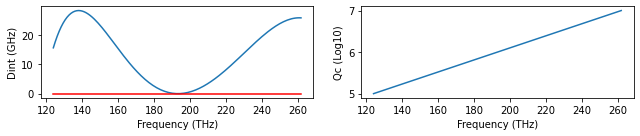

In [6]:
A = microring(R=20e-6,height=1e-6,width=2.3e-6,ng=2.2,Qc=1e6,Qi=1e6,n2=2.4e-19,
                δnorm_range=[-8,20],ω_range=[],λ_range=[],ω0=299792458/1.550e-6,λ0=None,
                total_time=1e-6,ω_sweep_speed=None,λ_sweep_speed=None,Qc_import=10**np.linspace(5.0,7.0,2**7),
                Dint_file='2.300w_58.5r_0.960h.csv',dt=1e-3,
                Nmodes=2**7,pump=50e-3,snapshots=2000,mode_offset=0,Dint_degrees=9)


In [7]:
A.split_step(plan_fft=True)

100%|██████████| 2000/2000 [01:54<00:00, 17.48it/s]


In [84]:
A.δarr

array([-1.54036142e+09+0.j, -1.54036121e+09+0.j, -1.54036100e+09+0.j, ...,
        3.85090314e+09+0.j,  3.85090335e+09+0.j,  3.85090356e+09+0.j])

In [85]:
def calc_disp_py(dt,dwext,dwi,dwtot,Dint_arr,darr):
    Dispersion = np.exp(-(dt/2)*((dwext+dwi)/dwtot+1j*(Dint_arr + darr)*2/dwtot ))
    return Dispersion

In [86]:
calc_disp_py(A.dt,A.Δωext,A.Δωi,A.Δωtot,A.Dint_arr,A.δarr[0])[1]

(0.9999962747480367+2.9763107385133513e-05j)

In [94]:
calc_disp(np.complex128(A.dt),np.complex128(A.Δωext),np.complex128(A.Δωi),np.complex128(A.Δωtot),np.complex128(A.Dint_arr),np.complex128(A.δarr[0]))

(0.9999962747480367+2.976310738513351e-05j)

In [107]:
%timeit calc_disp_py(a,b,c,d,e,f)

18.3 µs ± 63.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [122]:
a = np.complex128(A.dt)
b = np.complex128(A.Δωext)
c = np.complex128(A.Δωi)
d = np.complex128(A.Δωtot)
e = np.complex128(A.Dint_arr)
f = np.complex128(A.δarr[0])

In [99]:
%timeit calc_disp(a,b,c,d,e,f)

11.1 µs ± 109 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [46]:
Nsim=A.Nsim
dt = np.complex128(A.dt)
dwext = np.complex128(A.Δωext)
dwi = np.complex128(A.Δωi)
dwtot = np.complex128(A.Δωtot)
Dint_arr = np.complex128(A.Dint_arr)
detuning = np.complex128(A.δarr)
F_arr = np.complex128(A.F_arr)
ifft_arr = A.ifft_arr
fft_arr = A.fft_arr
ifft_object = A.ifft_object
fft_object = A.fft_object
noise_norm = A.noise_norm

In [44]:
divbysnapshot = A.Nsim//A.Nsnapshots

In [45]:
Nsnapshots = A.Nsnapshots

In [131]:
Nsim

3194615.0

In [47]:
import time
start = time.time()
ans = split_step_cython(Nsim,dt,dwext,dwi,dwtot,Dint_arr,detuning,F_arr,ifft_arr,fft_arr,ifft_object,fft_object,noise_norm,
                       divbysnapshot,Nsnapshots)
# split_step_cython(unsigned int Nsim, double complex dt,
#                       double complex[::1] dwext,double complex dwi,double complex dwtot,
#                       double complex[::1] Dint_arr,double complex detuning,
#                      double complex[::1] ifft_arr, double complex[::1] fft_arr, double complex[::1] F_arr,
#                      ifft_object,fft_object, double complex[::1] noise_norm)
end = time.time()
print(end-start)

TypeError: a bytes-like object is required, not 'tuple'

<StemContainer object of 3 artists>

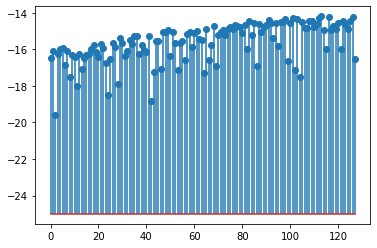

In [39]:
plt.stem(A.fftshift(np.log10(np.abs(np.array(ans))**2),A.idx),bottom=-25)

In [19]:
%time test_obj(ifft_object,fft_object)

CPU times: user 6.06 s, sys: 11.6 ms, total: 6.07 s
Wall time: 6.07 s


In [55]:
%%cython -a
import numpy as np
cimport cython
from cython.parallel import prange
import pyfftw
# from libc.complex cimport exp as cexp
# from libc.complex cimport abs as cabs

cdef extern from "complex.h":
    double complex exp(double complex z)
    double complex abs(double complex y)

@cython.cdivision(True)
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.nonecheck(False)
cpdef double complex[:,::1] split_step_cython(unsigned int Nsim, double complex dt,
    double complex[::1] dwext,double complex dwi,double complex dwtot,
    double complex[::1] Dint_arr,double complex[::1] detuning,
    double complex[::1] F_arr, unsigned int Nmodes,
    double complex[::1] noise_norm, unsigned int divbysnapshot,
    unsigned int Nsnapshots,pbar): # ifft_object,fft_object, double complex[::1] ifft_arr, double complex[::1] fft_arr, 
    
    cdef unsigned int Dlen = dwext.shape[0]
    cdef double complex[::1] Dispersion = np.zeros((Dlen),np.complex128)
    cdef unsigned int i
    cdef unsigned int j
    cdef unsigned int sol_track = 0
    cdef double complex[:,::1] sol = np.zeros((Nsnapshots,Dlen),np.complex128)
    cdef double complex[:] start = np.array(F_arr)*Nmodes*dt
    
    ifft_arr = pyfftw.empty_aligned(Nmodes,dtype='complex128',n=16) # frequency domain
    fft_arr = pyfftw.empty_aligned(Nmodes,dtype='complex128',n=16) # time domain
    fft_object = pyfftw.FFTW(fft_arr,ifft_arr,flags=('FFTW_MEASURE',))
    ifft_object = pyfftw.FFTW(ifft_arr,fft_arr,direction='FFTW_BACKWARD',flags=('FFTW_MEASURE',))
    ifft_arr[:] = start
    
    for i in range(Nsim):
        for j in range(Dlen):
            Dispersion[j] = exp(-(dt/2)*((dwext[j]+dwi)/dwtot+1j*(Dint_arr[j] + detuning[i])*2/dwtot ))
            # np.exp(-(dt/2) * ((dwext+dwi)/dwtot+1j*(Dint_arr + darr[i])*2/dwtot )) 
            ifft_arr[j] = Dispersion[j] * ifft_arr[j]
#         ifft_arr[:] = Dispersion * ifft_arr
        if i == 1:
            print(np.array(ifft_arr))
        ifft_object()
        if i == 1:
            print(np.array(ifft_arr))
        for j in range(Dlen):
            fft_arr[j] = exp(dt *(1j *  abs(fft_arr[j]) ** 2 + F_arr[j]/fft_arr[j])) * fft_arr[j]
#         fft_arr[:] = np.exp(dt *(1j *  np.abs(fft_arr) ** 2 + F_arr/fft_arr)) * fft_arr # equivalently you can add pump here (small speed-up in time domain)
        fft_object()
        for j in range(Dlen):
            ifft_arr[j] = Dispersion[j] * ifft_arr[j]
            ifft_arr[j] += noise_norm[j]
#         ifft_arr[:] = Dispersion * ifft_arr
        if (not((i+1)%divbysnapshot)) and sol_track<Nsnapshots:
            sol[sol_track] = ifft_arr.copy()
            sol_track += 1
            pbar.update(1)
    return sol

In [59]:
np.fft.ifft(A.F_arr)*A.Nmodes

array([-3.04279002e-08+1.92559306e-07j,  2.92142648e-07+9.48173126e-08j,
        4.93456635e-07+3.97041605e-07j, -2.48616758e-07+1.99558005e-07j,
       -3.88644728e-08-2.79742534e-07j, -4.42093774e-07+4.18768973e-07j,
       -4.95441604e-07-5.58372340e-07j,  3.47466354e-07-1.27313109e-07j,
       -1.92581092e-07-8.73205107e-08j,  3.45667367e-07-5.39568178e-08j,
        1.42001772e-07+3.36532568e-07j,  1.05191952e-07+8.01963370e-09j,
        1.24741418e-07-2.14649905e-07j, -5.66706451e-08+1.04821270e-07j,
        1.61769369e-07-2.02700312e-07j,  7.36519040e-08+3.07376109e-07j,
       -4.65793606e-07-4.10648946e-07j,  4.72640123e-07-7.90962365e-08j,
       -1.69921097e-08+2.07778173e-07j,  1.79057544e-07+3.90380905e-08j,
       -1.60803782e-07-1.45169957e-08j, -5.70811146e-08-5.04820637e-07j,
        4.92096415e-08+2.54677440e-07j, -1.64408567e-07+3.71463026e-07j,
       -2.66552411e-07+1.59160137e-08j,  1.18759681e-07-2.10262377e-07j,
        1.96704744e-07+2.44486478e-07j,  1.30476653